In [1]:
%%capture
# Import Dependencies
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
from datetime import datetime
import requests
import pandas_datareader as pdr
from datetime import datetime
import pandas_datareader as pdr
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# Function to Validate Tickers
def validateTick(tick):
    
    # Try Inputting into Yahoo Stocks
    try:
        pdr.DataReader(f'{tick}','yahoo',date)
    
    # Raise Error if Invalid
    except:
        raise ValueError("Ticker Not Valid.")
        
# Function to Validate Date
def validate(date_text):
    
    # Try Check on Format
    try:
        datetime.strptime(date_text, '%Y-%m-%d')
        
    # Raise Error if Invalid
    except ValueError:
        raise ValueError("Incorrect data format, should be YYYY-MM-DD")
        
# Function to Validate Date
def validateShift(shift):
    shift = int(shift)
    # Try Check on Format
    try:
        if 0 > shift <= 365:
            pass
        
    # Raise Error if Invalid
    except ValueError:
        raise ValueError("Please enter a whole number.")

In [3]:
# Pick a Start Date
date = input("Pick a start date for your analysis (YYYY-MM-DD): ")

# Validate Correct Date Format
validate(date)

Pick a start date for your analysis (YYYY-MM-DD):  2016-01-01


In [4]:
# Pick a Stock
stock_selection = input("Pick a stock ticker for your analysis: ")

# Validate Correct Date Format
validateTick(stock_selection)

Pick a stock ticker for your analysis:  CME


In [5]:
# Pick Shift
shift_selection = input("Pick how many days to shift your close values for your analysis: ")

# Validate Correct Date Format
validateShift(shift_selection)

Pick how many days to shift your close values for your analysis:  1


In [6]:
# Function to Create Stocks
def stockCreation(date, stock_selection, days_shifted):
    
    # Read Stock Data
    globals()[stock_selection] = pdr.DataReader(f'{stock_selection}','yahoo',date)
    
    # Create Shifted Close Column
    globals()[stock_selection]["Shifted Close"] = globals()[stock_selection]["Adj Close"].shift(-int(days_shifted))
    
    # Drop Rows Without Shift Values
    globals()[stock_selection].drop(globals()[stock_selection].tail(int(days_shifted)).index, inplace = True) 
    
    # Empty List to Hold Profit or Loss
    profit_loss = []
    
    # Iterate Through DataFrame
    for x in range(len(globals()[stock_selection])):
        
        # Handle Profitable Days
        if globals()[stock_selection]["Shifted Close"][x] > globals()[stock_selection]["Adj Close"][x]:
            
            # Append "Profit" to Empty List
            profit_loss.append(1)
            
        # Handle Loss Days
        elif globals()[stock_selection]["Shifted Close"][x] < globals()[stock_selection]["Adj Close"][x]:
            
            # Append "Loss" to Empty List
            profit_loss.append(0)
            
        # Handle Push Days
        elif globals()[stock_selection]["Shifted Close"][x] == globals()[stock_selection]["Adj Close"][x]:
            
            # Append "Push" to Empty List
            profit_loss.append(2)
    
    # Create Profit/Loss Column
    globals()[stock_selection]["Profit_Loss"] = profit_loss
    
    # Create Returns Column
    globals()[stock_selection]['Returns'] = np.log(globals()[stock_selection]['Adj Close'] / globals()[stock_selection]['Adj Close'].shift(1))
    
    # Iterate to Create STD Columns
    for x in range(5, 20, 5):
        
        # Create STD Column Based on Iteration
        col_name = 'std_' + str(x)
        
        # Add STD Column to DataFrame
        globals()[stock_selection][col_name] = globals()[stock_selection]['Adj Close'].rolling(window=x).std()

    # Iterate to Create MA Columns
    for x in range(10, 30, 5):
        
        # Create MA Column Based on Iteration
        col_name = 'ma_' + str(x)
        
        # Add MA Column to DataFrame
        globals()[stock_selection][col_name] = globals()[stock_selection]['Adj Close'].rolling(window=x).mean()

    # Iterate to Create % Change Columns
    for x in range(3, 12, 3):
        
        # Create % Change Column Based on Iteration
        col_name = 'pct_' + str(x)
        
        # Add % Change Column to DataFrame
        globals()[stock_selection][col_name] = globals()[stock_selection]['Adj Close'].pct_change().rolling(window=x).sum()

    # Create VMA 4 Column
    col_name = 'vma_4'
    
    # Add VMA 4 Column to DataFrame
    globals()[stock_selection][col_name] = globals()[stock_selection]['Volume'].rolling(4).mean()

    # Create Intraday Column
    col_name = 'co'
    
    # Add Intraday Column to DataFrame
    globals()[stock_selection][col_name] = globals()[stock_selection]['Adj Close'] - globals()[stock_selection]['Open']
    
    # Drop All NaN's
    globals()[stock_selection].dropna(inplace=True)
    
    # Return DataFrame
    return globals()[stock_selection]

In [7]:
# Create Stock dataframe
CMEdf = stockCreation(date, stock_selection, shift_selection)
CMEdf.head()

,High,Low,Open,Close,Volume,Adj Close,Shifted Close,Profit_Loss,Returns,std_5,...,std_15,ma_10,ma_15,ma_20,ma_25,pct_3,pct_6,pct_9,vma_4,co
Date,,,,,,,,,,,,,,,,,,,,,
2016-02-08,90.669998,87.000000,88.410004,90.190002,2758100.0,75.330887,77.936836,1,0.018351,1.218740,...,2.022289,73.756442,72.653080,72.354897,72.608648,0.009896,0.004898,0.044908,2910525.0,-13.079117
2016-02-09,93.809998,89.050003,89.050003,93.309998,3233500.0,77.936836,75.614868,0,0.034008,2.126921,...,2.423534,74.336102,73.053999,72.620506,72.763668,0.078829,0.044054,0.075449,3200800.0,-11.113167
2016-02-10,93.489998,90.440002,93.029999,90.529999,2133700.0,75.614868,74.604225,0,-0.030246,2.154174,...,2.382844,74.654331,73.406474,72.757486,72.802423,0.023321,0.017951,0.041389,2785025.0,-17.415131
2016-02-11,90.550003,88.320000,88.360001,89.320000,1952800.0,74.604225,76.132721,1,-0.013456,1.512457,...,1.967143,74.840592,73.814632,72.972562,72.815453,-0.008565,0.001331,-0.003668,2519525.0,-13.755775
2016-02-12,91.290001,89.510002,90.919998,91.150002,1691200.0,76.132721,75.765213,0,0.020281,1.253418,...,1.863000,74.949174,74.169889,73.241928,72.936396,-0.022671,0.056159,0.021383,2252800.0,-14.787277


In [8]:
#For simplicity, replace the “Close” price with the “Adjusted Close” price.
CMEdf['Close'] = CMEdf['Adj Close']
CMEdf = CMEdf.drop("Adj Close", axis=1)

In [9]:
#dropping the Profit Loss Column 
CMEdf = CMEdf.drop(columns=['Profit_Loss'])

In [10]:
CMEdf.head()

,High,Low,Open,Close,Volume,Shifted Close,Returns,std_5,std_10,std_15,ma_10,ma_15,ma_20,ma_25,pct_3,pct_6,pct_9,vma_4,co
Date,,,,,,,,,,,,,,,,,,,
2016-02-08,90.669998,87.000000,88.410004,75.330887,2758100.0,77.936836,0.018351,1.218740,1.268820,2.022289,73.756442,72.653080,72.354897,72.608648,0.009896,0.004898,0.044908,2910525.0,-13.079117
2016-02-09,93.809998,89.050003,89.050003,77.936836,3233500.0,75.614868,0.034008,2.126921,1.699434,2.423534,74.336102,73.053999,72.620506,72.763668,0.078829,0.044054,0.075449,3200800.0,-11.113167
2016-02-10,93.489998,90.440002,93.029999,75.614868,2133700.0,74.604225,-0.030246,2.154174,1.598326,2.382844,74.654331,73.406474,72.757486,72.802423,0.023321,0.017951,0.041389,2785025.0,-17.415131
2016-02-11,90.550003,88.320000,88.360001,74.604225,1952800.0,76.132721,-0.013456,1.512457,1.452542,1.967143,74.840592,73.814632,72.972562,72.815453,-0.008565,0.001331,-0.003668,2519525.0,-13.755775
2016-02-12,91.290001,89.510002,90.919998,76.132721,1691200.0,75.765213,0.020281,1.253418,1.509159,1.863000,74.949174,74.169889,73.241928,72.936396,-0.022671,0.056159,0.021383,2252800.0,-14.787277


In [11]:
#we want to predict the close price of 5 days in the future.

forward_lag = 5
CMEdf['target'] = CMEdf['Close'].shift(-forward_lag)
CMEdf = CMEdf.drop('Close',axis=1)
CMEdf = CMEdf.dropna()

In [12]:
X = CMEdf.drop("target",axis=1)
Y = CMEdf['target']

#split our dataset into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [13]:
#sort the features by the absolute value of the Pearson’s correlation coefficient of each feature and the target. 
#The idea is to take only the 50 most correlated features to the target.

correlations = np.abs(X_train.corrwith(y_train))
features =  list(correlations.sort_values(ascending=False)[0:50].index)
X_train = X_train[features]
X_test = X_test[features]

### The simplest regression model ever, which is Linear Regression

In [44]:
from sklearn.linear_model import LinearRegression

#train the model

lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [45]:
# calculate the predictions of the model
y_pred = lr.predict(X_test)

In [46]:
# The predictions can be compared with the real test set data to calculate the prediction error
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test,y_pred)

3.17667221594204

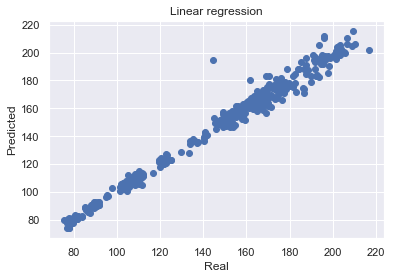

In [47]:
#plot the real values of the test set and the predicted value to check if they lie in a 45° line passing through 0

plt.scatter(y_test,y_pred)
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.title("Linear regression")
plt.show()

### Random forest

In [49]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [50]:
rf = RandomizedSearchCV(RandomForestRegressor(),
param_distributions =  {
                  'n_estimators':np.arange(10,500,5),
                  'max_features':np.arange(1,10,1)
               },
                  cv=5, n_iter = 20,
                  iid=False,random_state=0,refit=True,
                  scoring="neg_mean_absolute_error")
rf.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), iid=False,
                   n_iter=20,
                   param_distributions={'max_features': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([ 10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,  70,
        75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130, 135,
       140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200,
       205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265,
       270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330,
       335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395,
       400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460,
       465, 470, 475, 480, 485, 490, 495])},
                   random_state=0, scoring='neg_mean_absolute_error')

In [51]:
rf.best_params_

{'n_estimators': 285, 'max_features': 7}

In [52]:
y_pred = rf.predict(X_test)

In [53]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test,y_pred)

2.298402625512443

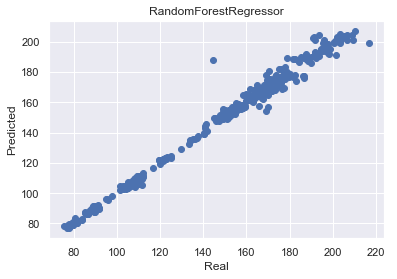

In [54]:
plt.scatter(y_test,y_pred)
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.title("RandomForestRegressor")
plt.show()

### Gradient boosting tree regressor

In [24]:
from sklearn.ensemble import GradientBoostingRegressor
gb = RandomizedSearchCV(GradientBoostingRegressor(),
param_distributions =  {
               'n_estimators':np.arange(10,500,5),
               'max_features':np.arange(1,10,1)
            },
          cv=5, n_iter = 20,
          iid=False,random_state=0,refit=True,
          scoring="neg_mean_absolute_error")
gb.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), iid=False,
                   n_iter=20,
                   param_distributions={'max_features': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([ 10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,  70,
        75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130, 135,
       140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200,
       205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265,
       270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330,
       335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395,
       400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460,
       465, 470, 475, 480, 485, 490, 495])},
                   random_state=0, scoring='neg_mean_absolute_error')

In [25]:
gb.best_params_

{'n_estimators': 480, 'max_features': 6}

In [26]:
y_pred = gb.predict(X_test)

In [27]:
mean_absolute_error(y_test,y_pred)

2.6094984056222135

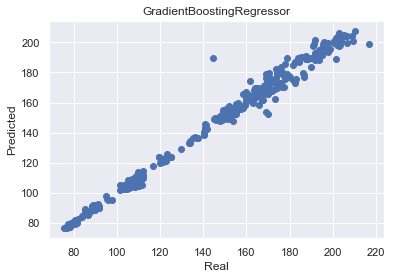

In [28]:
plt.scatter(y_test,y_pred)
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.title("GradientBoostingRegressor")
plt.show()

### K nearest neighbors

In [29]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

knn = GridSearchCV(KNeighborsRegressor(),
param_grid =  {
            'n_neighbors':np.arange(1,20,1),
            'weights':['distance','uniform']
            },
          cv=5, 
          iid=False,refit=True,
          scoring="neg_mean_absolute_error")
knn.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(), iid=False,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                         'weights': ['distance', 'uniform']},
             scoring='neg_mean_absolute_error')

In [30]:
knn.best_params_

{'n_neighbors': 17, 'weights': 'uniform'}

In [31]:
y_pred = knn.predict(X_test)

In [32]:
mean_absolute_error(y_test,y_pred)

33.01973035079101

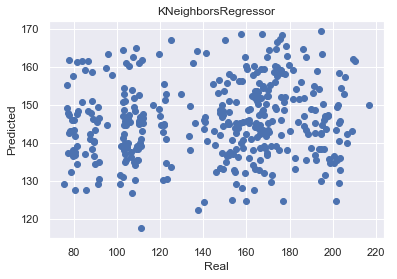

In [33]:
plt.scatter(y_test,y_pred)
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.title("KNeighborsRegressor")
plt.show()

## Neural network

In [34]:
from sklearn.neural_network import MLPRegressor

scaler = MinMaxScaler()
scaler.fit(X_train)
nnet = RandomizedSearchCV(MLPRegressor(max_iter=5000,learning_rate = 'adaptive',solver='sgd'),
param_distributions =  {
     'hidden_layer_sizes':[(x,) for x in np.arange(1,50,1)],
     'activation':['logistic','relu']
},
cv=5, n_iter = 20,
iid=False,random_state=0,refit=True,
scoring="neg_mean_absolute_error")

nnet.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=MLPRegressor(learning_rate='adaptive',
                                          max_iter=5000, solver='sgd'),
                   iid=False, n_iter=20,
                   param_distributions={'activation': ['logistic', 'relu'],
                                        'hidden_layer_sizes': [(1,), (2,), (3,),
                                                               (4,), (5,), (6,),
                                                               (7,), (8,), (9,),
                                                               (10,), (11,),
                                                               (12,), (13,),
                                                               (14,), (15,),
                                                               (16,), (17,),
                                                               (18,), (19,),
                                                               (20,), (21,),
             

In [35]:
y_pred = nnet.predict(X_test)

In [36]:
mean_absolute_error(y_test,y_pred)

33.28168575691424

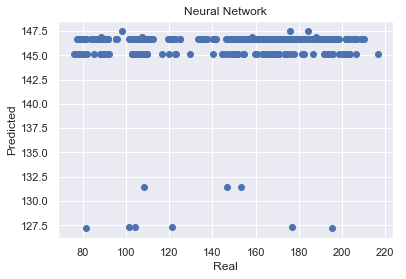

In [37]:
plt.scatter(y_test,y_pred)
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.title("Neural Network")
plt.show()

Here are the mean absolute errors for each model:
* Linear Regression: 3.17667221594204
* Random Forest: 2.289137045123017
* Gradient boosting regressor: 6.027036852638728
* K Nearest Neighbors: 50.8246064210463
* Neural Network: 52.120498966055195